Impulse: 9200.1080053


'Completed 5 iterations successfully. Total CPU time: 0.03125 s. Total wall time: 9.061605215072632 s'

Number of simulations:  5
Apogee Altitude -         Mean Value: 3247.189 m
Apogee Altitude - Standard Deviation: 63.273 m
3149.2566261918532
3343.5520965908468
2
97.14773519949676


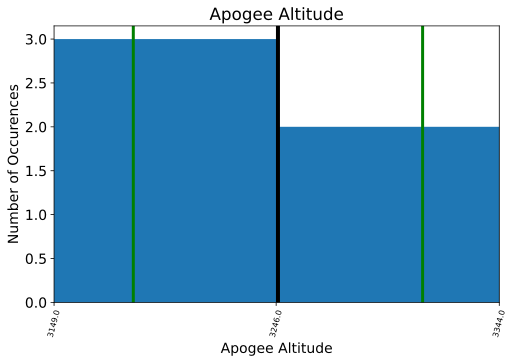

PROBABILITY THE Apogee Altitude IS IN BETWEEN 3017.52 AND 3078.48 IS: 0.37%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 3200.6451281549394, 3293.732201219627

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is 7.0393490045780975
Since our test statistic is less extreme than our critical value, we can NOT reject the null hypothesis that the mean is 3048.

Out Of Rail Stability Margin -         Mean Value: 2.250 m
Out Of Rail Stability Margin - Standard Deviation: 0.085 m
2.128250768339986
2.394404794158178
2
0.13307701290909613


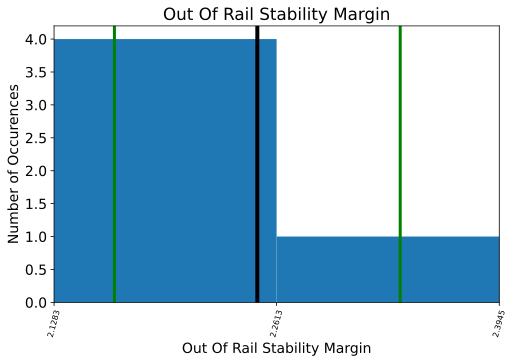

PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 100.0%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 2.1869475550062654, 2.3126568549021855


In [2]:
from time import process_time, time
from rocketpy import Environment, SolidMotor, Rocket, Flight
import concurrent.futures
from ConcurrentFunctions import runFlightWithMonteCarlo
from rocketpy.motors import motor
from IPython.display import display
from scipy.stats import norm
from rocketpy.mathutils.function import Function
from rocketpy.environment import environment

%config InlineBackend.figure_formats = ['svg']
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.rcParams["figure.figsize"] = [8, 5]
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["figure.titlesize"] = 14

import numpy as np

import logging

# Iterate the loop to read the cell values

dryMotorMass = 4.3367
grainInner =(43.942*10**-3)/2
grainOuter =(82.27*10**-3)/2
grainHeight = 0.1524
numGrain = 5
totalHeight = grainHeight*numGrain
centralAxis = (0.08333)*dryMotorMass*(grainOuter)**2
centralDiameter = ((1/4)*dryMotorMass*(grainOuter)**2) + (1/12)*dryMotorMass*(totalHeight)**2
the_nozzle_radius = (79.32*10**-3)/2
the_throat_radius= (29.21*10**-3)/2
the_nozzle_position = grainHeight*3.8
density = dryMotorMass / (((np.pi*grainOuter**2)-(np.pi*grainInner**2))*totalHeight)

# M1850W.all_info()

spMass = 16.4
spRadius = 0.155/2
spLength = .152 + .305 + .559 + .508 + .356 + .152

spCentralAxis = (spRadius**2)*spMass*1/2
spCentralDiameter = ((1/4)*spMass*(spRadius)**2) + (1/12)*spMass*(spLength)**2
the_center_of_mass_without_motor = 1.87

nose_cone_length = .813
the_fin_position = 2.62
boattailPos = 0.813+0.152+0.305+0.559+0.508+0.356+0.152
the_motor_position = spLength + nose_cone_length + grainHeight/2 - (totalHeight)/2
topRB = 2.79-0.274*2
drogueRadius = 0.61/2
drogueCdS = 0.97*3.1415*(drogueRadius)**2
lightRadius = 3.05/2
lightCdS = 2.2*3.1415*(lightRadius)**2


# In Fahrenheit
meanTemp = 80

envParams = {
    "latitude": 32.9823279,
    "longitude": -106.9490122,
    "elevation": 1400.556,
    "type": "custom_atmosphere",
}
env = Environment(latitude=envParams["latitude"], longitude=envParams["longitude"], elevation=envParams["elevation"],)

# Things to do: find out if rocket_center_of_dry_mass_position will be relative to rocket or not. IT IS.
the_motor_center_of_dry_mass_position = the_motor_position

burn_time = 2.505

_, _, points = motor.Motor.import_eng("thrustcurve.csv")
thrust_source = points
interpolation_method = "linear"
thrust = Function(thrust_source, "Time (s)", "Thrust (N)", interpolation_method, "zero")
impulse = thrust.integral(0, 2.505)
print("Impulse: " + str(impulse))


rocket_center_of_dry_mass_position = (the_center_of_mass_without_motor * spMass + the_motor_center_of_dry_mass_position * dryMotorMass) / (dryMotorMass + spMass)

analysis_parameters = {
    # Rocket's dry mass without motor (kg) and its uncertainty (standard deviation)
    "rocket_mass": (spMass, 0.001),
    # Rocket's inertia moment perpendicular to its axis (kg*m^2)
    "rocket_inertia_11": (spCentralDiameter, 0.036),
    # Rocket's inertia moment relative to its axis (kg*m^2)
    "rocket_inertia_33": (spCentralAxis, 0.00001),
    # Motors's dry mass without propellant (kg) and its uncertainty (standard deviation)
    "motor_dry_mass": (dryMotorMass, 0.001),
    # Motor's dry inertia moment perpendicular to its axis (kg*m^2)
    "motor_inertia_11": (centralAxis, 0.016),
    # Motors's dry inertia moment relative to its axis (kg*m^2)
    "motor_inertia_33": (centralDiameter, 0.00001),
    # Distance between rocket's center of dry mass and motor's center of dry mass (m)
    "motor_dry_mass_position": (np.abs(the_motor_center_of_dry_mass_position - rocket_center_of_dry_mass_position), 0.001),
    # Motor total impulse (N*s)
    "impulse": (impulse, 25.3),
    # Motor burn out time (s)
    "burn_time": (burn_time, .3),
    # Motor's nozzle radius (m)
    "nozzle_radius": (the_nozzle_radius, 0.5 / 1000),
    # Motor's nozzle throat radius (m)
    "throat_radius": (the_throat_radius, 0.5 / 1000),
    # Motor's grain separation (axial distance between two grains) (m)
    "grain_separation": (0, 1 / 1000),
    # Motor's grain density (kg/m^3)
    "grain_density": (density, 20),
    # Motor's grain outer radius (m)
    "grain_outer_radius": (grainOuter, 0.3 / 1000),
    # Motor's grain inner radius (m)
    "grain_initial_inner_radius": (grainInner, 0.3 / 1000),
    # Motor's grain height (m)
    "grain_initial_height": (grainHeight, 1 / 1000),
    # Rocket's radius (kg*m^2)
    "radius": (spRadius, 0.001),
    # Multiplier for rocket's drag curve. Usually has a mean value of 1 and a uncertainty of 5% to 10%
    "power_off_drag": (1, 0.05),
    # Multiplier for rocket's drag curve. Usually has a mean value of 1 and a uncertainty of 5% to 10%
    "power_on_drag": (1, 0.05),
    # Axial distance between rocket's center of dry mass and nearest point in its nose cone (m)
    "nose_distance_to_CM": (rocket_center_of_dry_mass_position-nose_cone_length, 0.001),
    # Axial distance between rocket's center of dry mass and nearest point in its fin (m)
    "fin_distance_to_CM": (the_fin_position - rocket_center_of_dry_mass_position, 0.001),
    # Launch rail inclination angle relative to the horizontal plane (degrees)
    "inclination": (88, 1),
    # Launch rail heading relative to north (degrees)
    "heading": (90, 2),
    # Drag coefficient times reference area for the drogue chute (m^2)
    "cd_s_drogue": (drogueCdS, 0.02),
    # Drag coefficient times reference area for the light chute
    "cd_s_light": (lightCdS, 0.02),
    # Time delay between parachute ejection signal is detected and parachute is inflated (s)
    "lag_rec": (0, 0.2),
    # Time delay between sensor signal is received and ejection signal is fired (s)
    "lag_se": (0, 0.1),
    # temperature in kelvin
    "temperature": ((meanTemp - 32) * 5/9 + 273.15, 5),
    # atmospheric pressure in pascals
    "atmosphere_pressure": (env.pressure_ISA(envParams["elevation"]), 300),
    # wind speed correspondign with u-vector in m/s
    "wind_u_speed": (0.44704, 0.044704),
    # wind speed corresponding with v-vector in m/s
    "wind_v_speed": (-4.4704, 0.33528)
}

# M1850W.all_info()

#sets up the ability to log inputs.
def setup_logging():
    class MyHandler(logging.FileHandler):
        def emit(self, record):
            super().emit(record)  # Call the superclass's emit method
            self.flush()  # Flush after each log message

    # Use your custom handler
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    handler = MyHandler('app.log', 'a')
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)

def createDistributionPlot(dispersonResultArray, name, lowerProbBound, upperProbBound, maxDecimals, percentConfidence, hypothesis):
    mean = np.mean(dispersonResultArray)
    deviation = np.std(dispersonResultArray)
    print(
        f'{name} -         Mean Value: {mean:0.3f} m'
    )
    print(
        f'{name} - Standard Deviation: {deviation:0.3f} m'
    )

    minimum = np.min(dispersonResultArray)
    print(minimum)
    maximum = np.max(dispersonResultArray)
    print(maximum)
    theBins = list()

    #using scott's rule to find the number of bins
    binWidth = 3.5 * deviation / np.power(len(dispersonResultArray), 1/3)
    numBins = int(np.round((maximum-minimum)/binWidth))

    print(numBins)
    changeInZ = (maximum - minimum) / numBins
    print(changeInZ)
    #test add
    zIterator = minimum
    for iterator in range(numBins):
        theBins.append(zIterator)
        zIterator += changeInZ
    finalValue = np.ceil(zIterator * np.power(10, maxDecimals)) / np.power(10, maxDecimals)
    theBins.append(finalValue)
    plt.figure()
    plt.xlim(minimum, maximum)
    minTextSize = 8
    maxTickCount = 50
    xTickBins = theBins
    if(numBins > maxTickCount):
        xTickBins = list()
        changeInZ = (maximum - minimum) / 50.0
        zIterator = minimum
        for iterator in range(50):
            xTickBins.append(zIterator)
            zIterator += changeInZ
    binListToString = list()
    for currentBin in xTickBins:
        binListToString.append(str(round(currentBin, maxDecimals)))
    plt.xticks(ticks = xTickBins, labels = binListToString, rotation = 75, fontsize = minTextSize)
    plt.hist(dispersonResultArray, bins=theBins)
    plt.title(name)
    plt.xlabel(name)
    plt.ylabel("Number of Occurences")

    plt.axvline(mean, color='k', linestyle='solid', linewidth=4)
    plt.axvline(mean - deviation, color='g', linestyle='solid', linewidth=3)
    plt.axvline(mean - 2*deviation, color='g', linestyle='solid', linewidth=3)
    plt.axvline(mean - 3*deviation, color='g', linestyle='solid', linewidth=3)
    plt.axvline(mean + deviation, color='g', linestyle='solid', linewidth=3)
    plt.axvline(mean + 2*deviation, color='g', linestyle='solid', linewidth=3)
    plt.axvline(mean + 3*deviation, color='g', linestyle='solid', linewidth=3)
    plt.show()
    lowerZ = (lowerProbBound - mean)/deviation
    upperZ = (upperProbBound - mean)/deviation
    probabilityInRange = norm.cdf(upperZ) - norm.cdf(lowerZ)
    print("PROBABILITY THE " + name +  " IS IN BETWEEN " + str(round(lowerProbBound, 4)) + " AND " + str(round(upperProbBound, 4)) + " IS: " + str(round(probabilityInRange * 100, 2)) + "%")
    if(percentConfidence != 100):
        aVal = (100 - percentConfidence)/100
        newZ = np.abs(norm.ppf(aVal/2))
        lowerBoundOfInterval = mean - newZ * deviation/np.sqrt(len(dispersonResultArray))
        upperBoundOfInterval = mean + newZ * deviation/np.sqrt(len(dispersonResultArray))
        print("There is a " + str(percentConfidence) + f"% chance that the mean of the " + name + 
              " falls within THIS RANGE: " + str(lowerBoundOfInterval) + ", " + str(upperBoundOfInterval))
        
        if(hypothesis != None):
            criticalValue = norm.ppf(aVal / 2)
            testStatistic = (mean - hypothesis) * np.sqrt(len(dispersonResultArray))/deviation
            print("\nWe have the hypothesis that our mean is greater than or equal to " + str(hypothesis) + ". With our critical percent, our critical value is " +
                str(criticalValue) + ". Then, our test statistic is " + str(testStatistic))
            if(testStatistic < criticalValue):
                print("Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is " + str(hypothesis) + ".\n")
            else:
                print("Since our test statistic is less extreme than our critical value, we can NOT reject the null hypothesis that the mean is " + str(hypothesis) + ".\n")

currentRow = 1
# envParams["file"] = row[0].value

#range only accepts integer values, so for now we make them integers and divide them later
for finDistance in range (2620, 2621, 25):
    setup_logging()
    analysis_parameters["fin_distance_to_CM"] = ((finDistance/1000) - rocket_center_of_dry_mass_position, 0.000)
    # env.all_info()
    # Create data files for inputs, outputs and error logging
    filename = "MonteCarlo" + str(finDistance)
    MonteCarloErrorFile = open(str(filename) + ".Errors.txt", "w")
    MonteCarloInputFile = open(str(filename) + ".Input.txt", "w")
    MonteCarloOutputFile = open(str(filename) + ".Output.txt", "w")

    initial_wall_time = time()
    initial_cpu_time = process_time()
    # Iterate over flight settings
    out = display("Starting", display_id=True)
    number_of_simulations = 5
    totalProcesses = 5
    simsPerProcess = number_of_simulations / totalProcesses

    #start multiprocessing
    if __name__ == "__main__":
        with concurrent.futures.ProcessPoolExecutor(max_workers=totalProcesses) as executor:
            results = [executor.submit(runFlightWithMonteCarlo, simsPerProcess, envParams, analysis_parameters, initial_cpu_time) for _ in range(totalProcesses)] 
            for result in concurrent.futures.as_completed(results):
                MonteCarloInputFile.write(result.result()[0] + "\n")
                MonteCarloOutputFile.write(result.result()[1] + "\n")
                MonteCarloErrorFile.write(result.result()[2] + "\n")

    ## Print and save total time
    final_string = f"Completed {number_of_simulations} iterations successfully. Total CPU time: {process_time() - initial_cpu_time} s. Total wall time: {time() - initial_wall_time} s"
    out.update(final_string)
    MonteCarloInputFile.write(final_string + "\n")
    MonteCarloOutputFile.write(final_string + "\n")
    MonteCarloErrorFile.write(final_string + "\n")

    ## Close files
    MonteCarloInputFile.close()
    MonteCarloOutputFile.close()
    MonteCarloErrorFile.close()

    # Initialize variable to store all results
    dispersion_general_results = []

    dispersion_results = {
        "out_of_rail_time": [],
        "out_of_rail_velocity": [],
        "apogee_time": [],
        "apogee_altitude": [],
        "apogee_x": [],
        "apogee_y": [],
        "impact_time": [],
        "impact_x": [],
        "impact_y": [],
        "impact_velocity": [],
        "initial_static_margin": [],
        "out_of_rail_static_margin": [],
        "out_of_rail_stability_margin": [],
        "final_static_margin": [],
        "number_of_events": [],
        "max_velocity": [],
        "drogue_triggerTime": [],
        "drogue_inflated_time": [],
        "drogue_inflated_velocity": [],
        "execution_time": [],
    }

    # Get all dispersion results
    # Get file
    dispersion_output_file = open(str(filename) + ".Output.txt", "r+")

    # Read each line of the file and convert to dict
    for line in dispersion_output_file:
        # Skip comments lines
        if line[0] != "{":
            continue
        # Eval results and store them
        flight_result = eval(line)
        dispersion_general_results.append(flight_result)
        for parameter_key, parameter_value in flight_result.items():
            dispersion_results[parameter_key].append(parameter_value)

    # Close data file
    dispersion_output_file.close()

    # Print number of flights simulated
    N = len(dispersion_general_results)
    print("Number of simulations: ", N)

    # Retrieve dispersion data por apogee and impact XY position
    apogee_x = np.array(dispersion_results["apogee_x"])
    apogee_y = np.array(dispersion_results["apogee_y"])
    impact_x = np.array(dispersion_results["impact_x"])
    impact_y = np.array(dispersion_results["impact_y"])
    createDistributionPlot(dispersion_results["apogee_altitude"], "Apogee Altitude", lowerProbBound = 9900 * 0.3048, upperProbBound = 10100 * 0.3048, maxDecimals = 0, percentConfidence = 90, hypothesis = 3048)

    createDistributionPlot(dispersion_results["out_of_rail_stability_margin"], "Out Of Rail Stability Margin", lowerProbBound = 1.5, upperProbBound = 4, maxDecimals = 4, percentConfidence = 90, hypothesis = None)


    # currentRow+=1